### How are citations resulting from a rear end collison distributed throughout the day?  How are they distributed by gender?

#### For this analysis I have narrowed the 'Citations' dataset to only those with a 'Charge Description' of *Failure to Control Speed to Avoid A Collision*.  This results in a total of 1,651 observations.

#### Recently, Arizona passed a hands-free cell phone law.  As future data is gathered, I'm interested if that law affects the number of rear end collisons that take place in Scottsdale. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pyodbc
import pandas as pd
import seaborn as sns
import datetime
from scipy.stats.kde import gaussian_kde

# plt.rcParams["figure.figsize"] = [15, 7]

# databaseConnection = 'DRIVER={SQL Server}; SERVER=ServerName; Database=DatbaseName; UID=UserId; PWD=password;'
connection = pyodbc.connect('DRIVER={SQL Server};SERVER=WINDOWS-A6S01I2\SQLEXPRESS;DATABASE=City_of_Scottsdale;Trusted_Connection=yes;')
cursor = connection.cursor()

# SQL query to import all citation data
citations = '''
  select * from [dbo].[spd_PDCitations$]  
  '''
citations = pd.read_sql(citations, connection)
connection.close()

# create Month and Day_of_Month columns
citations['Month'] = citations['Citation Date'].dt.month
citations['Day_of_Month'] = citations['Citation Date'].dt.day

citations['Day_of_Week'] = citations['Citation Date']. \
    apply(lambda x: x.strftime('%a')) #format Citation Day to represent day of week(Mon, Tu, Wed, ect.)

citations['Hour_of_Day'] = citations['Citation Time']. \
    apply(lambda x: str(x)[-7:-4]) # extract the hour of the day from the datetime column
citations['Hour_of_Day'] = pd.to_numeric(citations['Hour_of_Day'],errors='coerce')

#filter for only citations indicative of vehicle accidents
vehicular_accidents = citations \
    .loc[citations['Charge Description'] \
    .str.contains( \
    'Failure to Control Speed to Avoid A Collision')]

In [2]:
vehicular_accidents.head()

,tcmainid,Citation #,Citation Date,Citation Time,Arizona Statute Code,Charge Description,Citation Type Code,Citation Type Description,Officer Badge #,Street Number,...,Zone,Cited Person,Cited Person Age,Cited Person Race,Cited Person Sex,Cited Person Ethnicity,Month,Day_of_Month,Day_of_Week,Hour_of_Day
2,621806.0,2056700.0,2018-06-23,1053.0,28-701A,Failure to Control Speed to Avoid A Collision,CV,Civil Traffic,1360.0,xxx,...,2501.0,"Glasscock, James",60.0,W,M,N,6,23,Sat,10.0
62,593393.0,2016624.0,2017-10-26,756.0,28-701A,Failure to Control Speed to Avoid A Collision,CV,Civil Traffic,1405.0,8xxx,...,712.0,"Garcia, Wade",48.0,W,M,H,10,26,Thu,7.0
130,593482.0,2048126.0,2017-10-26,1702.0,28-701A,Failure to Control Speed to Avoid A Collision,CV,Civil Traffic,650.0,4xxx,...,1109.0,"Bates, Diane",61.0,W,F,N,10,26,Thu,17.0
133,593500.0,2046886.0,2017-10-26,1643.0,28-701A,Failure to Control Speed to Avoid A Collision,CV,Civil Traffic,1326.0,1xxx,...,3401.0,"Schlitzer, Maddy",23.0,W,F,N,10,26,Thu,16.0
292,591049.0,2045907.0,2017-10-07,1334.0,28-701A,Failure to Control Speed to Avoid A Collision,CV,Civil Traffic,1390.0,xxx,...,3401.0,"Daoust, Michael",25.0,W,M,N,10,7,Sat,13.0


### How are accidents distributed by time of day?

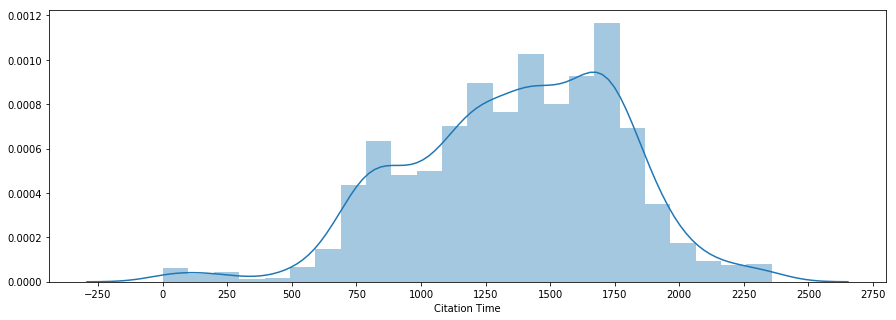

In [9]:
fig = plt.figure(figsize=(15, 5))

ax = sns.distplot(vehicular_accidents['Citation Time'], bins=24)
ax.xaxis.set_major_locator(ticker.MultipleLocator(250))
plt.savefig('visualizations/accidents distributed by time of day.png')

### How are accidents distributed by month of the year?

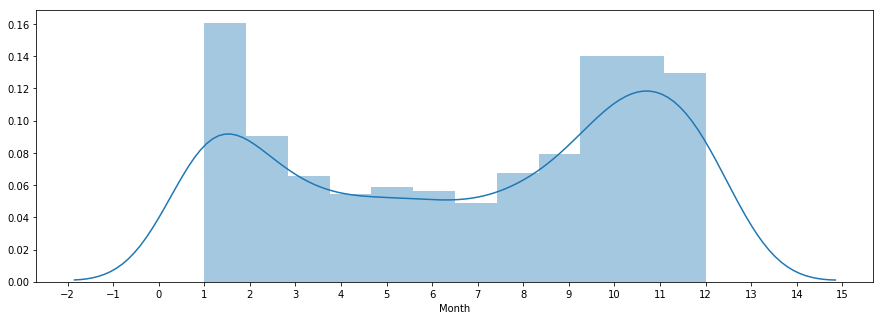

In [4]:
# how are accidents distrubuted throughout the year?
fig = plt.figure(figsize=(15, 5))

ax = sns.distplot(vehicular_accidents['Month'], bins=12)
ax.xaxis.set_major_locator(ticker.MultipleLocator())

### How are accidents distributed by gender?

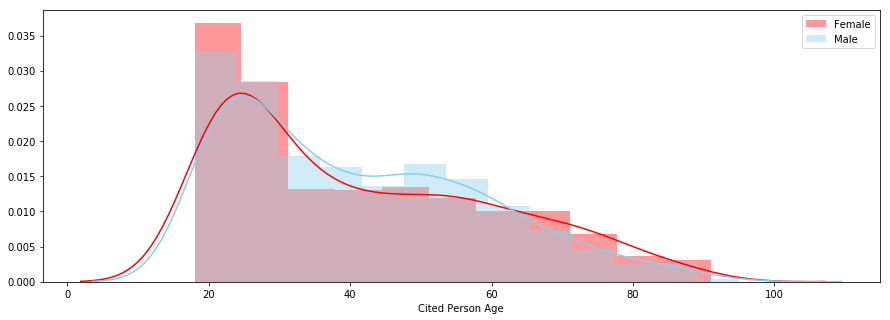

In [5]:
fig = plt.figure(figsize=(15, 5))

sns.distplot(vehicular_accidents[vehicular_accidents['Cited Person Sex'] == 'F'] \
             .loc[:,'Cited Person Age'], color="red", label="Female")

sns.distplot(vehicular_accidents[vehicular_accidents['Cited Person Sex'] == 'M'] \
             .loc[:,'Cited Person Age'], color="skyblue", label="Male")

plt.legend()

### How are accidents distributed by age?

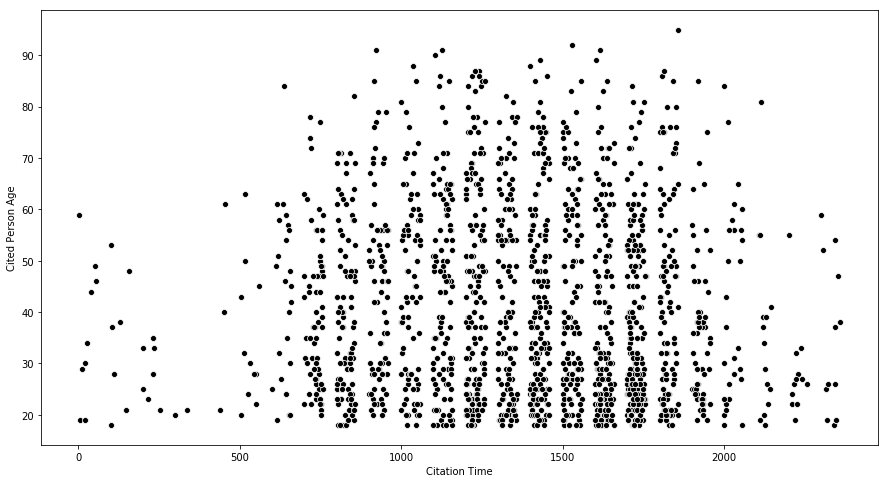

In [6]:
fig = plt.figure(figsize=(15, 8))

sns.scatterplot(x=vehicular_accidents['Citation Time'], 
                y=vehicular_accidents['Cited Person Age'], color='black')

#how are accidents distributed by age

### How are accidents distributed by both age and gender?

In [39]:
# my first opportunity using pivot_table functiont to shape data into tidy format, I think it's more efficient

pivot_table = pd.pivot_table(vehicular_accidents, \
               index=['Hour_of_Day','Cited Person Sex'], \
               columns=['Cited Person Age'], \
               aggfunc=['count'], \
               values=['tcmainid']).reset_index()

pivot_table.head()

Hour_of_Day Cited Person Sex    count                      \
                                              tcmainid                       
Cited Person Age                                  18.0 19.0 20.0 21.0 22.0   
0                        1.0                F      NaN  NaN  NaN  1.0  NaN   
1                        1.0                M      1.0  NaN  NaN  NaN  NaN   
2                        2.0                F      NaN  NaN  NaN  NaN  NaN   
3                        2.0                M      NaN  NaN  NaN  1.0  NaN   
4                        3.0                M      NaN  NaN  1.0  1.0  NaN   

                                ...                                           \
                                ...                                            
Cited Person Age 23.0 24.0 25.0 ...  84.0 85.0 86.0 87.0 88.0 89.0 90.0 91.0   
0                 NaN  NaN  NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1                 NaN  NaN  NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2                 NaN  NaN  1.0 ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3                 1.0  NaN  NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4                 NaN  NaN  NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                            
                            
Cited Person Age 92.0 95.0  
0                 NaN  NaN  
1                 NaN  NaN  
2                 NaN  NaN  
3                 NaN  NaN  
4                 NaN  NaN  

[5 rows x 78 columns]

In [42]:
pivot_table_long = pd.melt(pivot_table, id_vars=['Cited Person Sex', 'Hour_of_Day'], value_vars='count').dropna()
pivot_table_long.head()

,Cited Person Sex,Hour_of_Day,variable_0,variable_1,variable_2,value
1,M,1.0,count,tcmainid,18,1.0
13,F,8.0,count,tcmainid,18,2.0
14,M,8.0,count,tcmainid,18,2.0
18,M,10.0,count,tcmainid,18,2.0
19,F,11.0,count,tcmainid,18,2.0


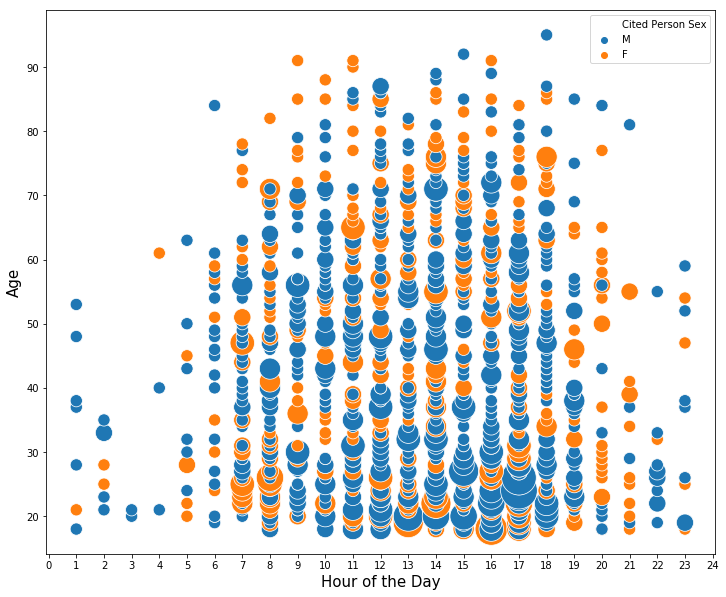

In [69]:
fig = plt.figure(figsize=(12, 10))
ax = sns.scatterplot(x=pivot_table_long['Hour_of_Day'], 
                y=pivot_table_long['variable_2'], 
                hue=pivot_table_long['Cited Person Sex'],
                s=pivot_table_long['value']*150)

plt.xlabel("Hour of the Day", fontsize=15)
plt.ylabel("Age", fontsize=15)

ax.xaxis.set_major_locator(ticker.MultipleLocator())

### Distribution using age, gender, and a swarmplot format.

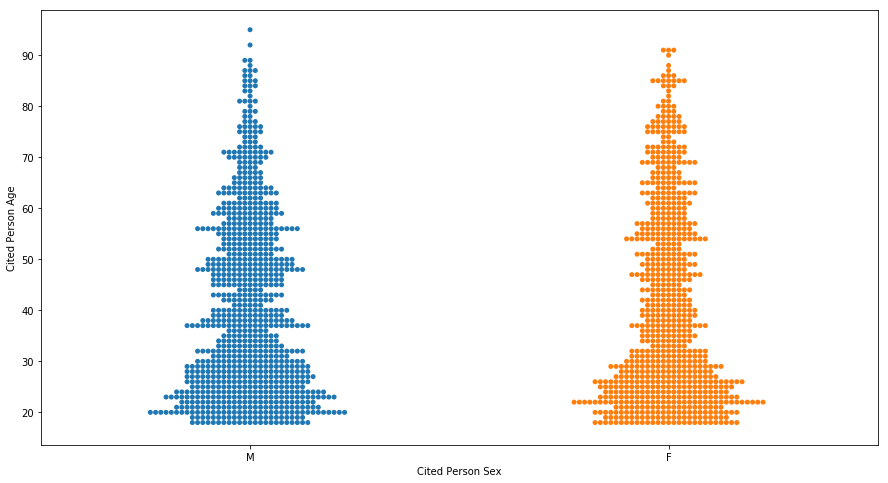

In [10]:
fig = plt.figure(figsize=(15, 8))

sns.swarmplot(x=vehicular_accidents['Cited Person Sex'], 
                y=vehicular_accidents['Cited Person Age'])

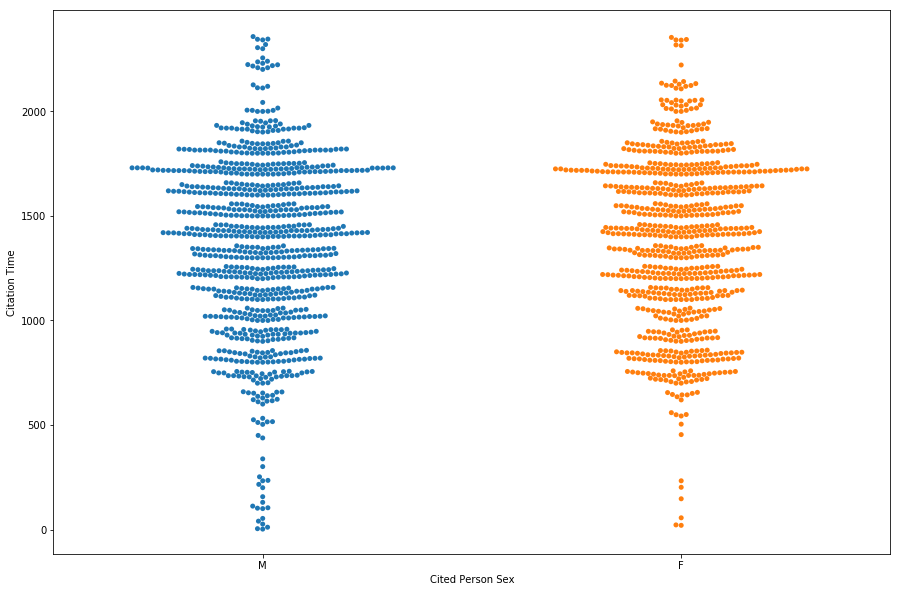

In [11]:
fig = plt.figure(figsize=(15, 10))

sns.swarmplot(x=vehicular_accidents['Cited Person Sex'], 
                y=vehicular_accidents['Citation Time'])